# [Survival Analysis :  Quick Implementation](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e)

In [1]:
import pandas as pd
import numpy as np

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis

import seaborn as sb
import matplotlib.pyplot as plt
%pylab inline
figsize(12,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Example with a fictitious data

<AxesSubplot:xlabel='timeline'>

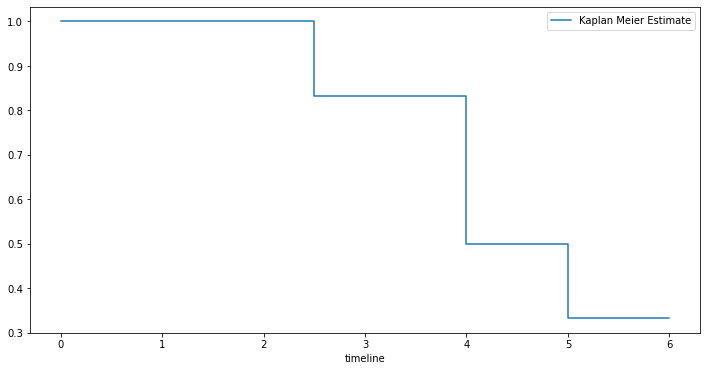

In [2]:
from lifelines import KaplanMeierFitter

## Example Data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

## create an kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

## Real World Example 

### We will be using Telco Customer Churn data from Kaggle
https://www.kaggle.com/blastchar/telco-customer-churn/

In [3]:
##  create a dataframe
df=pd.read_csv("./Telco-Customer-Churn.csv") 

In [4]:
## Have a first look at the data
df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
## Data Types and Missing Values in Columns
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [7]:
## after converting the column TotalCharges to numeric
df.info()  ## Column TotalCharges is having missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
## Impute the null value with the median value
df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [9]:
## lets have a look at the categories and their distribution in all the categorical columns.

# for i in cat_cols:
#     print('Column Name: ',i)
#     print(df[i].value_counts())
#     print('-----------------------------')

## Cox Proportional Hazard Model (Survival Regression)

In [10]:
from lifelines import CoxPHFitter

In [11]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [12]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [13]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [14]:
cph.print_summary()    ## HAve a look at the significance of the features

C:\Users\2joon\anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2022-08-30 01:40:45 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40                 0.50
Dependents_Yes                   -0.36       0.70       0.07            -0.49            -0.22                 0.61                 0.80
PhoneService_Yes                  0.69       2.00       0.10             0.49             0.90                 1.63                 2.45
StreamingTV_No internet service  -2.10       0.12       0.13            -2.36            -1.84                 0.09                 0.16
StreamingTV_Yes                  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                                  cmp to      z      p   -log2(p)
covariate                                                        
MonthlyCharges                      0.00  -6.13 <0.005      30.06
SeniorCitizen                       0.00   7.16 <0.005      40.15
gender_Male                         0.00  -0.23   0.82       0.29
Partner_Yes                         0.00 -14.93 <0.005     164.98
Dependents_Yes                      0.00  -5.21 <0.005      22.37
PhoneService_Yes                    0.00   6.65 <0.005      34.96
StreamingTV_No internet service     0.00 -15.79 <0.005     184.09
StreamingTV_Yes                     0.00  -3.10 <0.005       9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

<AxesSubplot:xlabel='log(HR) (95% CI)'>

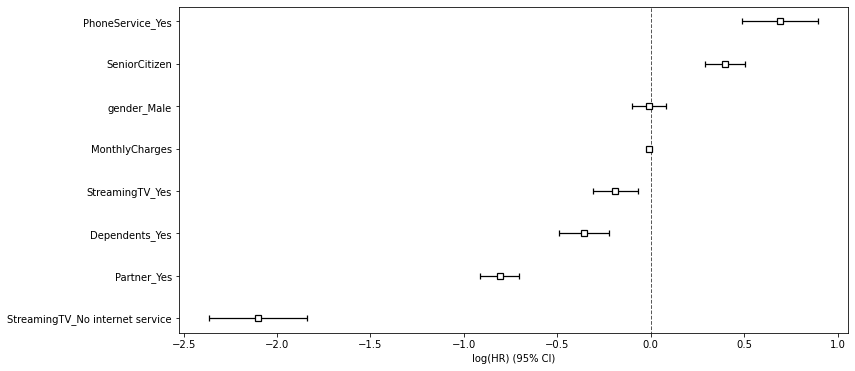

In [15]:
cph.plot()

In [16]:
# Check all the methods and attributes associated with the cph object.
# dir(cph)

In [17]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


<AxesSubplot:>

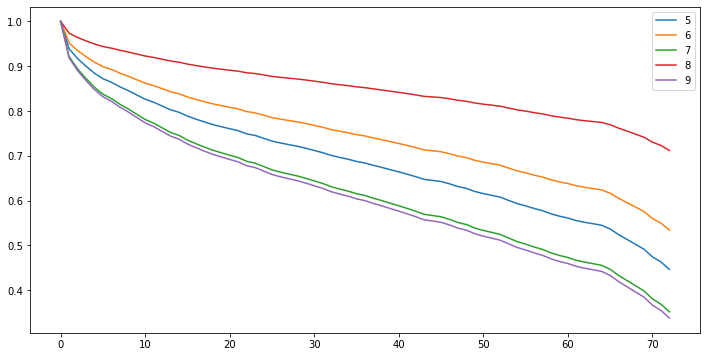

In [18]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

In [20]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows)

,5,6,7,8,9
0.0,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.938943,0.952209,0.921628,0.973824,0.918728
2.0,0.917315,0.935115,0.894221,0.964317,0.890368
3.0,0.900133,0.921472,0.872583,0.956671,0.868002
4.0,0.884537,0.909038,0.853048,0.949657,0.847828
...,...,...,...,...,...
68.0,0.502361,0.585595,0.409905,0.748382,0.396028
69.0,0.491407,0.575645,0.398364,0.741468,0.384453
70.0,0.474358,0.560060,0.380551,0.730526,0.366615
71.0,0.463062,0.549665,0.368854,0.723151,0.354917
